# Выборка и агрегация данных в MongoDB

###Цель домашней работы

Закрепить на практике основные приемы работы с СУБД MongoDB, включая выборку, сортировку, объединение, агрегацию данных и передачу результатов выборки в программу на Python в целях аналитики и дальнейшей обработки.

### Формулировка задания

В этом задании вам предстоит выполнить несколько запросов к базе данных для получения выборок по условиям, а также воспользоваться фреймворком агрегации MongoDB для построения конвейера обработки данных.

Максимальное количество баллов за выполнение домашней работы: 10.

##Что нужно использовать в работе над заданием

I. MongoDB:

1. Зарегистрируйтесь в сервисе MongoDB Atlas: https://www.mongodb.com/atlas/database.
1. Создайте кластер уровня M0 (это бесплатно).
1. Добавьте в кластер тестовую базу данных `sample_mflix`, используя опцию Load Sample Dataset.

В качестве альтернативы вы можете установить MongoDB на свой локальный компьютер и импортировать необходимые датасеты в свою СУБД, загрузив их по ссылке: https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix. Для этого подключитесь к своему серверу через Compass, создайте новую БД, создайте для каждого датасета коллекцию и щелкните «Add data» → «Import JSON or CSV file».

II. MongoDB Compass — в качестве вспомогательного инструмента для конструирования запросов и агрегаций.

III. Python и библиотека pymongo. Работа ведется в Jupyter Notebook или Google Colaboratory. Рекомендуется использовать версию Python 3.12.

##Ожидаемые результаты

Результаты работы необходимо оформить в виде ноутбука Jupyter. Можно загрузить файл в LMS либо поделиться ссылкой на Google Colaboratory.

##Место где нужно выполнить задание



In [65]:
import pandas as pd
import numpy as np
import warnings
import pymongo
import os
import certifi
import seaborn as sns
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
load_dotenv()
mongodb_user = os.getenv("mongodb_user")
mongodb_password = os.getenv("mongodb_password")
cluster = os.getenv("cluster")

In [2]:
client = pymongo.MongoClient(f"mongodb+srv://{mongodb_user}:{mongodb_password}@{cluster}",
                             tlsCAFile=certifi.where())
print(client.list_database_names())  # Вывести список БД для проверки подключения

['my_database', 'sample_airbnb', 'sample_analytics', 'sample_geospatial', 'sample_guides', 'sample_mflix', 'sample_restaurants', 'sample_supplies', 'sample_training', 'sample_weatherdata', 'admin', 'local']


### Упражнение 1. Запросы на выборку

Цель этого упражнения — закрепить навык выполнения запросов на выборку. Все запросы выполняются на базе `sample_mflix` с данными о кинофильмах.

#### Задача 1.1 — **1 балл**

Выведите из коллекции `theaters` документы о кинотеатрах в городе Florence, штат KY.

Для справки:

* Обратите внимание на то, что информация об адресе кинотеатров хранится во вложенных документах. Для доступа к полям вложенных документов следует использовать точку: `родительский_документ.вложенный_документ.поле`.
* В случае затруднений с написанием логического условия обращайтесь к сопоставлению синтаксиса SQL и Mongo: https://www.mongodb.com/docs/manual/reference/sql-comparison/.
* Если вы предпочитаете сперва выполнять запросы в Compass, из этого приложения можно выгружать код готового запроса на Python (кнопка с символом `</>`).

In [6]:
collection_theaters = client['sample_mflix']['theaters']
list(collection_theaters.find({"location.address.city": 'Florence',
                               "location.address.state": 'KY'}))

[{'_id': ObjectId('59a47287cfa9a3a73e51e893'),
  'theaterId': 161,
  'location': {'address': {'street1': '100 Meijer Dr.',
    'city': 'Florence',
    'state': 'KY',
    'zipcode': '41042'},
   'geo': {'type': 'Point', 'coordinates': [-84.636383, 39.014843]}}},
 {'_id': ObjectId('59a47287cfa9a3a73e51ea02'),
  'theaterId': 2823,
  'location': {'address': {'street1': '2823 Florence Mall',
    'street2': '#2148',
    'city': 'Florence',
    'state': 'KY',
    'zipcode': '41042'},
   'geo': {'type': 'Point', 'coordinates': [-84.6499595, 38.9967246]}}}]

#### Задача 1.2 — **1 балл**

Сделав запрос к коллекции `comments`, выведите _один_ комментарий (значение поля `text`) пользователя по имени Doreah.

In [28]:
collection_comments = client['sample_mflix']['comments']
result = list(collection_comments.find({"name": 'Doreah'}))
result[0]['text']

'Id provident odio numquam perferendis. Dolores eum itaque aspernatur voluptatem quasi sint maiores. Quam culpa porro debitis quisquam modi quisquam deleniti.'

#### Задача 1.3 — **1 балл**

Сделав запрос к коллекции `movies`, выведите количество документов, в которых в качестве первого жанра фильма (поле `genres`) указано значение «Horror».

Для справки:

1. Обратите внимание, что поле `genres` представляет собой массив (индексация массивов начинается с нуля).
1. При работе в MongoDB Shell для подсчета количества документов в курсоре можно использовать метод `count()`, однако он был удален в последних версиях библиотеки pymongo. В случае затруднений с использованием функций Mongo можно использовать для подсчета документов средства Python.

In [29]:
collection_movies = client['sample_mflix']['movies']
result = list(collection_movies.find({"genres":
                                        {"$elemMatch":{"$eq":'Horror'}
                                      }
                                   }
                                 )
                               )
count = 0
for item in result:

    if item['genres'][0] == 'Horror': count += 1
print(f"Количество жанров: {count}")

Количество жанров: 700


#### Задача 1.4 — **2 балла**

Выведите из коллекции `movies` документы о фильмах, которые в качестве первого жанра определены как «Film-Noir» либо «Horror» и были выпущены в период с 1940 по 1949 гг. (включительно).

In [34]:
result = list(collection_movies.find({ 'genres.0':
                                       {'$in': ['Film-Noir', 'Horror']},
                                       'year':{'$gt':1940,'$lte': 1949}}))
len(result)

7

#### Задача 1.5 — **1 балл**

Модифицируйте запрос из задачи 1.4 таким образом, чтобы осуществить _проекцию_: результатом выборки должен стать список словарей, каждый из которых содержит только два поля: `title` и `year`.

Для справки о проекции см. документацию по методу `find()` в pymongo:
https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.find

In [50]:
result = collection_movies.find({ 'genres.0':
                                       {'$in': ['Film-Noir', 'Horror']},
                                       'year':{'$gt':1940,'$lte': 1949},
                                       },
                                     projection = ['title', 'year'],
                                     sort = [('year', 1)])
list(result)

[{'_id': ObjectId('573a1393f29313caabcdc814'),
  'title': 'Cat People',
  'year': 1942},
 {'_id': ObjectId('573a1393f29313caabcdcd9d'),
  'title': 'I Walked with a Zombie',
  'year': 1943},
 {'_id': ObjectId('573a1393f29313caabcdcdf5'),
  'title': 'The Leopard Man',
  'year': 1943},
 {'_id': ObjectId('573a1393f29313caabcdd38c'),
  'title': 'The Body Snatcher',
  'year': 1945},
 {'_id': ObjectId('573a1393f29313caabcdd3ed'),
  'title': 'Dead of Night',
  'year': 1945},
 {'_id': ObjectId('573a1393f29313caabcdd6e7'),
  'title': 'The Chase',
  'year': 1946},
 {'_id': ObjectId('573a1393f29313caabcde460'),
  'title': 'The Set-Up',
  'year': 1949}]

### Упражнение 2. Конвейер агрегации

#### Задача 2.1 — **3 балла**

В рамках этой задачи требуется узнать, какие фильмы получили наибольшее число комментариев. Составьте для этого конвейер агрегации с перечисленными ниже этапами. Для удобства рекомендуется воспользоваться приложением Compass.

1. Сгруппировать документы коллекции `comments` по полю `movie_id` и подсчитать количество комментариев для каждого фильма, записав его в поле `count`.
1. Отсортировать получившийся набор данных по убыванию количества комментариев (так чтобы первый документ в этом наборе указывал на фильм с наибольшим количеством комментариев).
1. Используя оператор `$lookup`, присоединить коллекцию `movies` (по полю `movie_id`).
1. Выполнить проекцию, оставив в наборе данных только три поля: название фильма (`title`), год выпуска (`year`) и количество комментариев (поле `count`, добавленное на первом этапе). Для этого воспользуйтесь оператором `$project`: https://www.mongodb.com/docs/manual/reference/operator/aggregation/project/. Обратите внимание, что данные из коллекции `movies` (`title` и `year`) на этом этапе окажутся внутри массива.
1. Применить оператор `$unwind`, чтобы деконструировать этот массив. См. https://www.mongodb.com/docs/manual/reference/operator/aggregation/unwind/. В результате массив должен превратиться в одиночный объект.
1. Применить оператор `$addFields`, чтобы добавить поля `title` и `year` на вернхий уровень структуры документа. См. https://www.mongodb.com/docs/manual/reference/operator/aggregation/addFields/.
1. Еще раз выполнить проекцию, чтобы удалить поле с массивом.

Ваш алгоритм решения может отличаться от приведенного здесь. Главное — достичь цели: получить плоский набор данных с тремя полями (`count` — количество комментариев, `year` — год выпуска, `title` — название фильма).

Скопируйте полученный конвейер в этот документ в виде кода на Python и выведите его на экран в виде списка словарей.

In [62]:
res = collection_comments.aggregate([
    {
        '$group': {
            '_id': '$movie_id',
            'count': {
                '$count': {}
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }, {
        '$lookup': {
            'as': 'movie_info',
            'from': 'movies',
            'foreignField': '_id',
            'localField': '_id'
        }
    }, {
        '$project': {
            'movie_info.title': 1,
            'movie_info.year': 1,
            'count': 1
        }
    }, {
        '$unwind': {
            'path': '$movie_info',
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$addFields': {
            'title': '$movie_info.title',
            'year': '$movie_info.year'
        }
    }, {
        '$project': {
            'count': 1,
            'year': 1,
            'title': 1
        }
    }
])
data = list(res)
data

[{'_id': ObjectId('573a13bff29313caabd5e91e'),
  'count': 161,
  'title': 'The Taking of Pelham 1 2 3',
  'year': 2009},
 {'_id': ObjectId('573a13b3f29313caabd3b647'),
  'count': 158,
  'title': 'Terminator Salvation',
  'year': 2009},
 {'_id': ObjectId('573a13abf29313caabd25582'),
  'count': 158,
  'title': '50 First Dates',
  'year': 2004},
 {'_id': ObjectId('573a13a5f29313caabd159a9'),
  'count': 158,
  'title': 'About a Boy',
  'year': 2002},
 {'_id': ObjectId('573a13a3f29313caabd0d1e3'),
  'count': 158,
  'title': "Ocean's Eleven",
  'year': 2001},
 {'_id': ObjectId('573a139bf29313caabcf3a45'),
  'count': 157,
  'title': 'The Mummy',
  'year': 1999},
 {'_id': ObjectId('573a13bcf29313caabd57db6'),
  'count': 157,
  'title': 'Sherlock Holmes',
  'year': 2009},
 {'_id': ObjectId('573a13b0f29313caabd3505e'),
  'count': 155,
  'title': 'Hellboy II: The Golden Army',
  'year': 2008},
 {'_id': ObjectId('573a13a0f29313caabd05ae1'),
  'count': 154,
  'title': 'The Mummy Returns',
  'year':

#### Задача 2.2 — **1 балл**

Используя данные, полученные в задаче 2.1, выведите на экран столбчатую диаграмму, показывающую топ-20 наиболее комментируемых фильмов. По оси ординат выведите названия этих фильмов (подписи разместите слева диаграммы), по оси абсцисс — количество комментариев.

Для решения задачи можно использовать любую библиотеку, например Seaborn или Matplotlib.

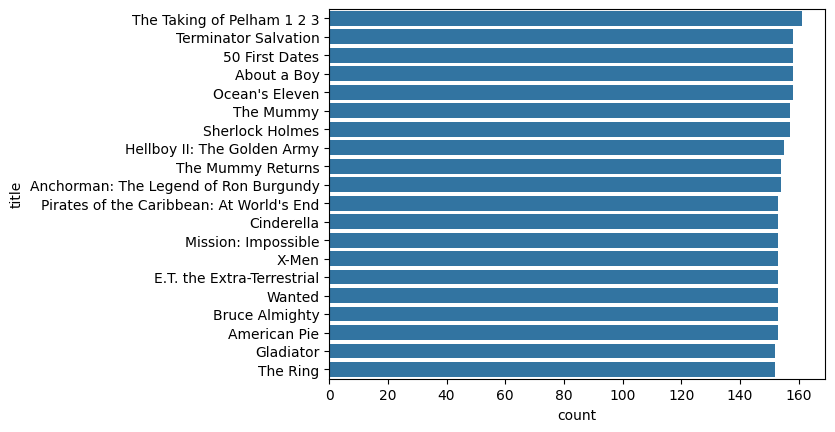

In [67]:
data_viz = pd.DataFrame(data =data)
data_viz = data_viz.iloc[:20]
data_viz
sns.barplot(data = data_viz, x = 'count', y = 'title');